In [ ]:
library(caret)
library(pROC)
install.packages('gbm')
install.packages("e1071")

In [266]:
cars <- read.csv('Cars_mileage.csv', stringsAsFactors=FALSE)

In [267]:
str(cars)

'data.frame':	397 obs. of  9 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : int  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : chr  "130" "165" "150" "150" ...
 $ weight      : int  3504 3693 3436 3433 3449 4341 4354 4312 4425 3850 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ year        : int  70 70 70 70 70 70 70 70 70 70 ...
 $ origin      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ name        : chr  "chevrolet chevelle malibu" "buick skylark 320" "plymouth satellite" "amc rebel sst" ...


In [268]:
sum(cars == '?')

[1] 5

In [269]:
cars <- cars[!(cars$horsepower == '?'),] # only 5 records with missing values, so delete them

In [270]:
cars$horsepower <- as.numeric(cars$horsepower) # the str() readout showed this using the character data type

In [271]:
summary(cars)

      mpg          cylinders      displacement     horsepower        weight    
 Min.   : 9.00   Min.   :3.000   Min.   : 68.0   Min.   : 46.0   Min.   :1613  
 1st Qu.:17.00   1st Qu.:4.000   1st Qu.:105.0   1st Qu.: 75.0   1st Qu.:2225  
 Median :22.75   Median :4.000   Median :151.0   Median : 93.5   Median :2804  
 Mean   :23.45   Mean   :5.472   Mean   :194.4   Mean   :104.5   Mean   :2978  
 3rd Qu.:29.00   3rd Qu.:8.000   3rd Qu.:275.8   3rd Qu.:126.0   3rd Qu.:3615  
 Max.   :46.60   Max.   :8.000   Max.   :455.0   Max.   :230.0   Max.   :5140  
  acceleration        year           origin          name          
 Min.   : 8.00   Min.   :70.00   Min.   :1.000   Length:392        
 1st Qu.:13.78   1st Qu.:73.00   1st Qu.:1.000   Class :character  
 Median :15.50   Median :76.00   Median :1.000   Mode  :character  
 Mean   :15.54   Mean   :75.98   Mean   :1.577                     
 3rd Qu.:17.02   3rd Qu.:79.00   3rd Qu.:2.000                     
 Max.   :24.80   Max.   :82.00  

*The station wagon (sw) and diesel notations in the name data could be useful predictors, so add these as binary features. The origin and year features are not really numerical, so transform them to factors. The cylinder feature can remain numerical since there is a numerical relationship, e.g. an 8-cylinder car has twice as many cylinders as a 4-cylinder car.*

In [272]:
cars <- transform(cars, wagon = ifelse(grepl('\\(sw\\)', name), 'yes', 'no'))

In [273]:
cars <- transform(cars, diesel = ifelse(grepl('diesel', name), 'yes', 'no'))

In [274]:
cars$year <- factor(cars$year, levels = c(70:82),
                    labels = c('Y70','Y71','Y72','Y73','Y74','Y75','Y76','Y77','Y78','Y79','Y80','Y81','Y82'))

In [275]:
cars$origin <- factor(cars$origin, levels = c(1,2,3), labels = c('US', 'Europe', 'Japan'))

In [276]:
mpg_median = median(cars$mpg) # create the binary feature mpg_binary; using median ensures balanced classes

In [277]:
cars <- transform(cars, mpg_binary = mpg>mpg_median)

In [278]:
str(cars)

'data.frame':	392 obs. of  12 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : int  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : num  130 165 150 150 140 198 220 215 225 190 ...
 $ weight      : int  3504 3693 3436 3433 3449 4341 4354 4312 4425 3850 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ year        : Factor w/ 13 levels "Y70","Y71","Y72",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ origin      : Factor w/ 3 levels "US","Europe",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ name        : chr  "chevrolet chevelle malibu" "buick skylark 320" "plymouth satellite" "amc rebel sst" ...
 $ wagon       : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ diesel      : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ mpg_binary  : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...


*Compute counts and ratios for use in bar plots of the factor and binary features, as well as the cylinders feature, since it contains only five distinct values.*

In [279]:
year_mpg <- data.frame(high_mpg = tapply(cars$mpg_binary, cars$year, sum), num_models =
                         tapply(cars$year, cars$year, length))
year_mpg <- transform(year_mpg, ratio = high_mpg/num_models)

In [280]:
diesel_mpg <- data.frame(high_mpg = tapply(cars$mpg_binary, cars$diesel, sum), num_models =
                         tapply(cars$diesel, cars$diesel, length))
diesel_mpg <- transform(diesel_mpg, ratio = high_mpg/num_models)

In [281]:
origin_mpg <- data.frame(high_mpg = tapply(cars$mpg_binary, cars$origin, sum), num_models =
                         tapply(cars$origin, cars$origin, length))
origin_mpg <- transform(origin_mpg, ratio = high_mpg/num_models)

In [282]:
wagon_mpg <- data.frame(high_mpg = tapply(cars$mpg_binary, cars$wagon, sum), num_models =
                         tapply(cars$wagon, cars$wagon, length))
wagon_mpg <- transform(wagon_mpg, ratio = high_mpg/num_models)

In [283]:
cyl_factors <- as.factor(cars$cylinders)
cyl_mpg <- data.frame(high_mpg = tapply(cars$mpg_binary, cyl_factors, sum), num_models =
                         tapply(cyl_factors, cyl_factors, length))
cyl_mpg <- transform(cyl_mpg, ratio = high_mpg/num_models)

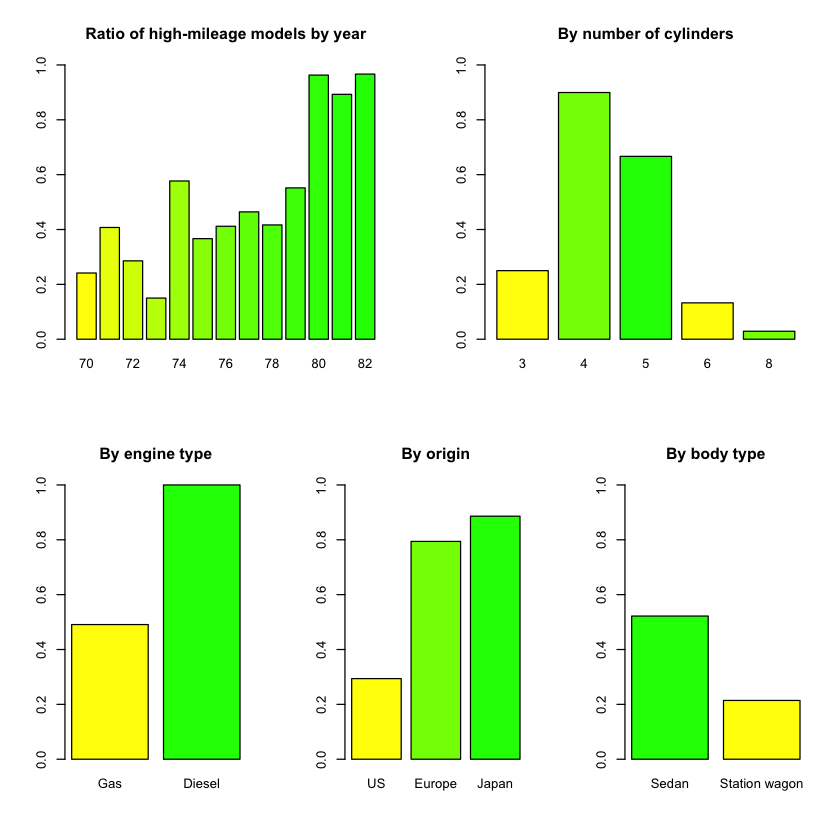

In [284]:
#png('/Users/vince/Desktop/job\ applications/Azavea/data-analyst-data-test/factor_plots.png')
layout(matrix(c(1,1,1,2,2,2,3,3,4,4,5,5), 2, 6, byrow = TRUE))
barplot(year_mpg$ratio, names.arg=c(70:82), ylim=c(0, 1.0), col=rainbow(13,start=1/6, end=1/3),
        main='Ratio of high-mileage models by year')
cylinders <- data.frame(factors = as.factor(cars$cylinders), values = cars$mpg)
barplot(cyl_mpg$ratio, names.arg=levels(cylinders$factors), ylim=c(0, 1.0), col=rainbow(3, start=1/6, end=1/3),
        main='By number of cylinders')
barplot(diesel_mpg$ratio, names.arg=c('Gas', 'Diesel'), ylim=c(0, 1.0), col=rainbow(2, start=1/6, end=1/3),
        main='By engine type')
barplot(origin_mpg$ratio, names.arg=levels(cars$origin), ylim=c(0, 1.0),
        col=rainbow(3, start=1/6, end=1/3), main='By origin')
barplot(wagon_mpg$ratio, names.arg=c('Sedan', 'Station wagon'), ylim=c(0, 1.0), col=rainbow(2, start=1/3, end=1/6),
        main='By body type')
#dev.off()

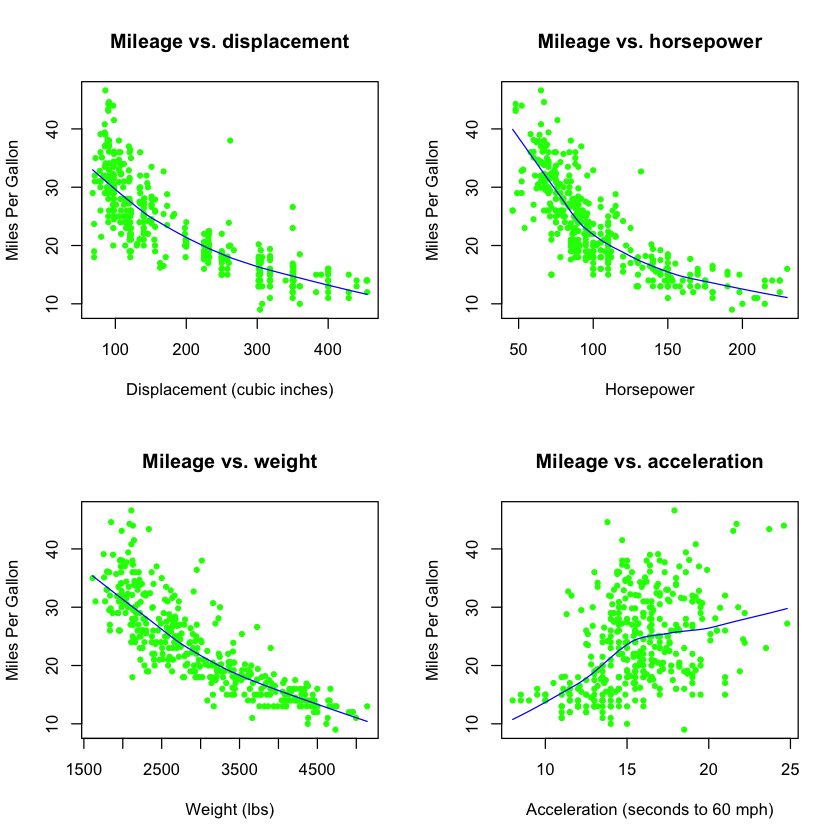

In [285]:
#png('/Users/vince/Desktop/job\ applications/Azavea/data-analyst-data-test/scatter_plots.png')
par(mfrow=c(2,2))
plot(cars$displacement, cars$mpg, main='Mileage vs. displacement', xlab='Displacement (cubic inches)', ylab='Miles Per Gallon', pch=20, col='green')
lines(lowess(cars$displacement,cars$mpg), col="blue")
plot(cars$horsepower, cars$mpg, main='Mileage vs. horsepower', xlab='Horsepower', ylab='Miles Per Gallon', pch=20, col='green')
lines(lowess(cars$horsepower,cars$mpg), col="blue")
plot(cars$weight, cars$mpg, main='Mileage vs. weight', xlab='Weight (lbs)', ylab='Miles Per Gallon', pch=20, col='green')
lines(lowess(cars$weight,cars$mpg), col="blue")
plot(cars$acceleration, cars$mpg, main='Mileage vs. acceleration', xlab='Acceleration (seconds to 60 mph)', ylab='Miles Per Gallon', pch=20, col='green')
lines(lowess(cars$acceleration,cars$mpg), col="blue")
#dev.off()

*From the plots, it appears that the single most useful predictor is whether or not the car has a diesel engine, since all of the diesel cars in the data set get above-median mileage. Origin and number of cylinders also look to be good predictors. Horsepower and displacement also look good, but they and weight look very much alike and seem highly correlated. Model year looks not so good overall, but models from the years '80-'82 are almost all in the high mileage category. Likewise, body type does not seem very useful. Station wagons get almost uniformly low mileage, but represent a small subset of the data. Acceleration does not seem useful at all, except that the cars with the fastest acceleration all get low mileage.* 

In [286]:
cars$mpg_binary <- factor(cars$mpg_binary, levels = c(F,T), labels = c('low', 'high'))

*Dataset is ready to use in a classifier. Create class-balanced train and test sets. Use a random forest algorithm first.*

In [288]:
set.seed(555)
inTrain <- createDataPartition(y = cars$mpg_binary, p = .7, list = FALSE)
train_rf <- cars[inTrain,]
test_rf <- cars[-inTrain,]

In [289]:
ctrl <- trainControl(method='repeatedcv', number=5, repeats=10)
grid_rf <- expand.grid(.mtry = c(3,4,5))
clf <- train(mpg_binary ~ ., data=train_rf[,!colnames(train_rf) %in% c('mpg', 'name', 'weight', 'horsepower')],
             method='rf', metric='Kappa', trControl=ctrl, tuneGrid=grid_rf)

In [290]:
clf

Random Forest 

276 samples
  7 predictor
  2 classes: 'low', 'high' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 221, 221, 220, 221, 221, 220, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  3     0.9358480  0.8716731
  4     0.9384002  0.8767722
  5     0.9376599  0.8752868

Kappa was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 4. 

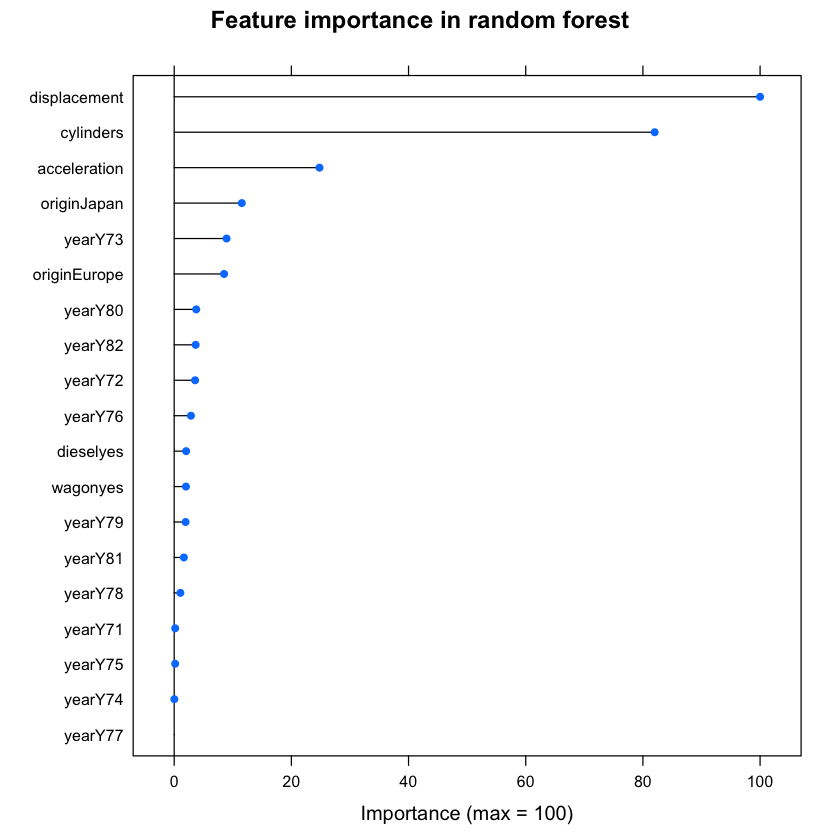

In [326]:
#png('/Users/vince/Desktop/job\ applications/Azavea/data-analyst-data-test/var_imp_rf.png')
plot(varImp(clf), main='Feature importance in random forest', xlab='Importance (max = 100)')
#dev.off()

In [292]:
model_test <- predict(clf, newdata=test_rf)

In [293]:
confusionMatrix(data = model_test, test_rf$mpg_binary)

Confusion Matrix and Statistics

          Reference
Prediction low high
      low   50    4
      high   8   54
                                          
               Accuracy : 0.8966          
                 95% CI : (0.8263, 0.9454)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7931          
 Mcnemar's Test P-Value : 0.3865          
                                          
            Sensitivity : 0.8621          
            Specificity : 0.9310          
         Pos Pred Value : 0.9259          
         Neg Pred Value : 0.8710          
             Prevalence : 0.5000          
         Detection Rate : 0.4310          
   Detection Prevalence : 0.4655          
      Balanced Accuracy : 0.8966          
                                          
       'Positive' Class : low             
                                          

*Different seeds produced test accuracies +/- 0.015 of the 0.90 reported here, so the test error rate is approximately 10%. As expected,* displacement, weight *and* horsepower *did not go well together, and the best results were obtained by keeping only* horsepower,* which had the highest importance score. Interestingly, dropping* acceleration *— which seemed the worst predictor — decreased performance slightly. I varied the numbers of cross-validation folds and repeats, the number of trees and the train/test split percentage. The only significantly different results came from changing the train/split to 75/25, which produced higher training scores but lower test scores, indicative of overfitting.* 

In [303]:
ctrl <- trainControl(method='repeatedcv', number=5, repeats=10, returnResamp='none',
                     summaryFunction = twoClassSummary, classProbs = TRUE)
clf_gbm <- train(mpg_binary ~ ., data=train_rf[,!colnames(train_rf) %in% c('mpg', 'name')],
             method='gbm', metric='ROC', trControl=ctrl, preProc = c("center", "scale"), verbose=FALSE)

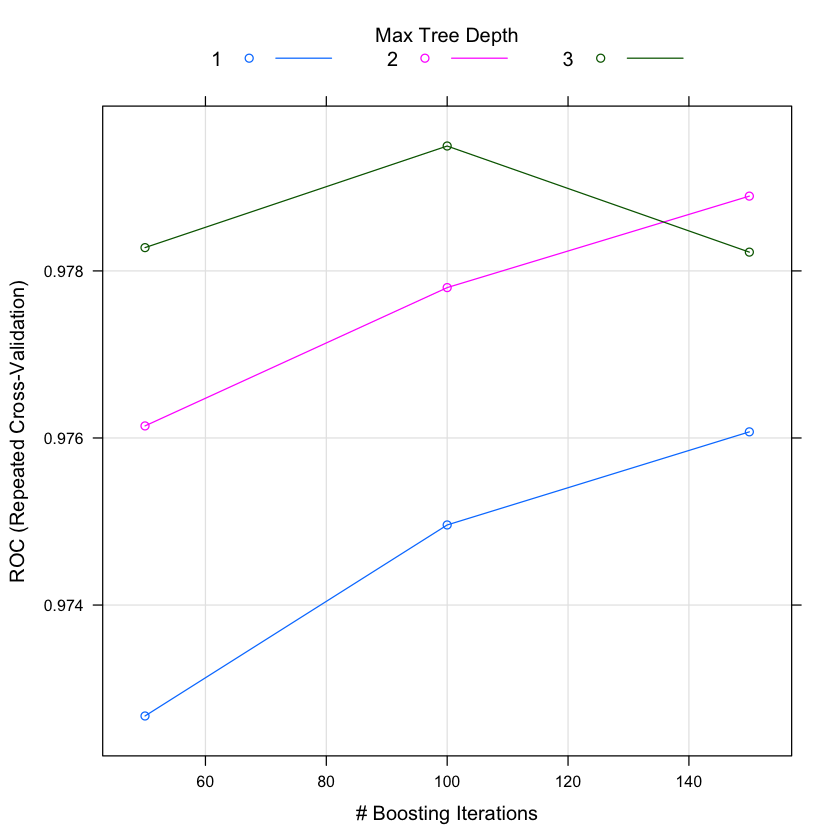

In [304]:
plot(clf_gbm)

In [305]:
gbm_test <- predict(clf_gbm, newdata=test_rf)

In [306]:
confusionMatrix(data = gbm_test, test_rf$mpg_binary)

Confusion Matrix and Statistics

          Reference
Prediction low high
      low   52    3
      high   6   55
                                          
               Accuracy : 0.9224          
                 95% CI : (0.8578, 0.9639)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8448          
 Mcnemar's Test P-Value : 0.505           
                                          
            Sensitivity : 0.8966          
            Specificity : 0.9483          
         Pos Pred Value : 0.9455          
         Neg Pred Value : 0.9016          
             Prevalence : 0.5000          
         Detection Rate : 0.4483          
   Detection Prevalence : 0.4741          
      Balanced Accuracy : 0.9224          
                                          
       'Positive' Class : low             
                                          

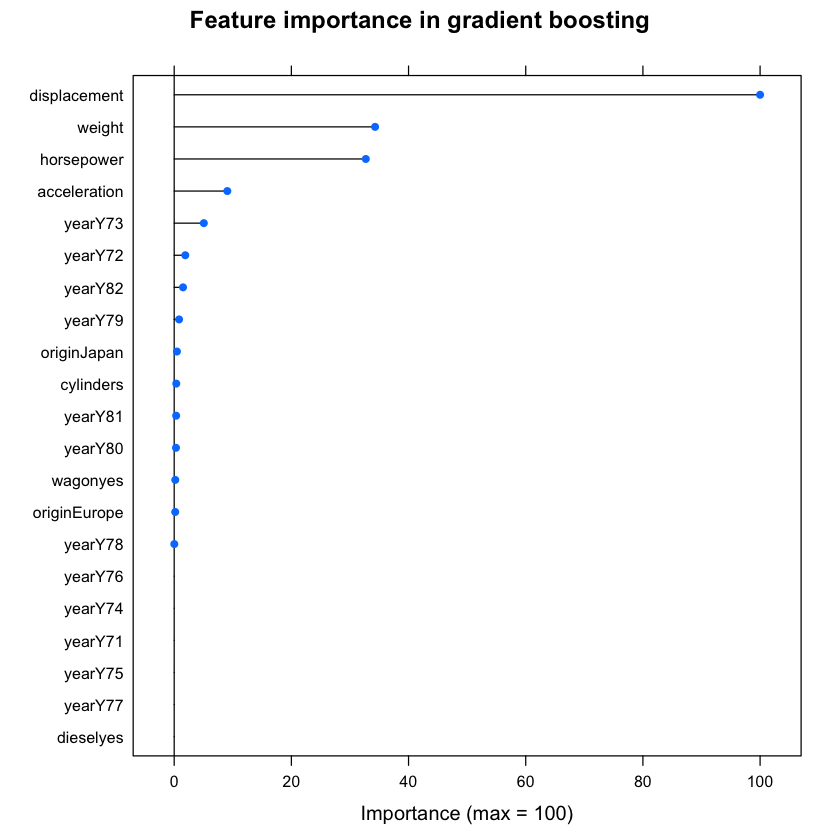

In [328]:
#png('/Users/vince/Desktop/job\ applications/Azavea/data-analyst-data-test/var_imp_gbm.png')
plot(varImp(clf_gbm), main='Feature importance in gradient boosting', xlab='Importance (max = 100)')
#dev.off()

*The gradient boosting algorithm produced better results with the same train/test split, and was significantly quicker. The reported accuracy of 0.92 indicates a testing error of approximately 8%. It also assigned importance to fewer features, as can be seen by the eighth-ranked feature, Y79, already being almost on the zero line. In contrast, the random forest algorithm had 15 features that ranked higher than Y79 did using gradient boosting. Interestingly, removing* weight *and* horsepower *decreased the gradient boosting performance. They ranked second and third after* displacement.